# 3.3 類似文章検索のファインチューニング

本ノートブックでは、Notebook「3-1_text_similarity_train.ipynb」にてファインチューニングしたモデルの評価を行います。

## 事前準備

### (1) ライブラリのインストール

利用するライブラリをインストールします。

In [1]:
! pip install datasets matplotlib japanize-matplotlib
! pip install fugashi unidic_lite
! pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 36.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.1 MB/s eta 0:00:00
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=885c389a986c934828f88596666f574df3d36e308d47f8b9c93c69f80a7aa2de
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-1

### 定数の定義

In [2]:
MODEL_NAME = "cl-tohoku/bert-base-japanese-v3"  # 利用するモデル名

# google driveに保存した場合
from google.colab import drive
drive.mount("/content/drive")
MODEL_INPUT = "drive/MyDrive/output_jsts"  # モデルの格納場所

# 実行環境に保存した場合
# MODEL_INPUT = "./output_jsts"

Mounted at /content/drive


### 乱数シードの設定

In [3]:
from transformers.trainer_utils import set_seed

set_seed(2024)

### (2) データセットの準備

In [4]:
from datasets import load_dataset

# データセットの読み込み
valid_dataset = load_dataset(
    "shunk031/JGLUE", name="JSTS", split="validation",trust_remote_code=True
    )

# データセットの概要を表示する
print("評価データ")
print(valid_dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

評価データ
Dataset({
    features: ['sentence_pair_id', 'yjcaptions_id', 'sentence1', 'sentence2', 'label'],
    num_rows: 1457
})


## 評価

ファインチューニングしたモデルを評価します。

### (1) ファインチューニング済みモデルとトークナイザの読み込み

トークナイザとモデルを準備します。

In [5]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# 利用するデバイスの確認（GPU or CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# モデルのロード
model = (AutoModelForSequenceClassification
    .from_pretrained(MODEL_INPUT, ignore_mismatched_sizes=True)
    .to(device))

# tokenizerのロード
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/231k [00:00<?, ?B/s]

### (2) 推論

パイプライン（Pipelines）を用いて推論を実行します。Google ColabのCPU環境で実行すると、約4分ほど時間がかかります。

In [6]:
from transformers import pipeline

pipe = pipeline(
    "text-classification",
    model=model,
    function_to_apply="none",  # 出力に適用する関数の指定
    tokenizer=tokenizer,
    device=device,
)


In [7]:
from tqdm import tqdm

# 予測結果をresultsに格納
results: list[dict[str, float | str]] = []
for i, example in tqdm(enumerate(valid_dataset)):
    # モデルの予測結果を取得
    model_prediction = pipe({"text": example["sentence1"], "text_pair": example["sentence2"]})

    # resultsに分析に必要な情報を格納
    results.append(
        {
            "example_id": i,
            "pred_score": model_prediction["score"],
            "true_score": example["label"],
        }
    )

1457it [04:05,  5.92it/s]


### (3) 精度の評価

推論した結果を評価します。

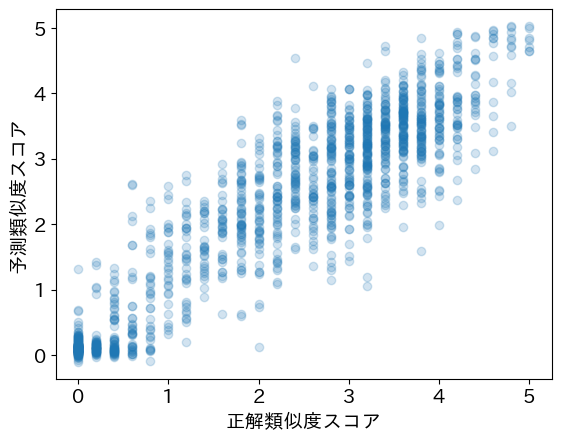

In [8]:
import japanize_matplotlib
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 14  # フォントサイズ設定

plt.xlabel("正解類似度スコア")
plt.ylabel("予測類似度スコア")

plt.scatter(
    [i["true_score"] for i in results],
    [i["pred_score"] for i in results],
    alpha=0.2
)


plt.show()